## Start

In [1]:
from sklearn.ensemble import RandomForestClassifier
import requests
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as BS
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, plot_confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
df_TSLA_Senti=pd.read_csv('tesla_baseline_sentiment_data')

In [3]:
df_TSLA_Senti.head()

,Unnamed: 0,OBV,RSI,Vader_neg,Vader_neu,Vader_pos,Vader_compound,article_count,TextBlob_article_polarity,TextBlob_article_subjectivity,TextBlob_snippet_polarity,TextBlob_snippet_subjectivity,TextBlob_lead_polarity,TextBlob_lead_subjectivity,Green
0,2014-01-02,1190817660,0.000000,0.031000,0.869000,0.101000,0.994900,1,0.104228,0.433051,0.000000,0.000000,0.250000,0.283333,1
1,2019-01-02,1396718105,0.000000,0.053750,0.877000,0.069250,0.391675,4,0.107059,0.393232,0.002083,0.189583,0.175000,0.150000,1
2,2018-01-03,1948048885,0.000000,0.053000,0.817000,0.130000,0.992750,2,0.082165,0.433961,-0.137500,0.312500,0.350000,0.300000,1
3,2019-01-03,1361975220,0.000000,0.069667,0.839667,0.090333,0.909767,3,0.126922,0.440809,0.245833,0.483333,0.208333,0.394444,1
4,2018-01-04,1898325920,57.882067,0.051500,0.858750,0.090000,0.966500,4,0.075833,0.423203,0.093561,0.359091,0.225000,0.241667,0


In [4]:
df_TSLA_Senti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1312 non-null   object 
 1   OBV                            1312 non-null   int64  
 2   RSI                            1312 non-null   float64
 3   Vader_neg                      1312 non-null   float64
 4   Vader_neu                      1312 non-null   float64
 5   Vader_pos                      1312 non-null   float64
 6   Vader_compound                 1312 non-null   float64
 7   article_count                  1312 non-null   int64  
 8   TextBlob_article_polarity      1312 non-null   float64
 9   TextBlob_article_subjectivity  1312 non-null   float64
 10  TextBlob_snippet_polarity      1312 non-null   float64
 11  TextBlob_snippet_subjectivity  1312 non-null   float64
 12  TextBlob_lead_polarity         1312 non-null   f

In [5]:
## drop the date duplicate
df_TSLA_Senti= df_TSLA_Senti.rename(columns={"Unnamed: 0" : "Date"})
# df_TSLA_Senti.drop(['Unnamed: 0'], axis=1, inplace=True)
# df_TSLA_Senti.set_index('date', inplace=True)

df_TSLA_Senti.head()

,Date,OBV,RSI,Vader_neg,Vader_neu,Vader_pos,Vader_compound,article_count,TextBlob_article_polarity,TextBlob_article_subjectivity,TextBlob_snippet_polarity,TextBlob_snippet_subjectivity,TextBlob_lead_polarity,TextBlob_lead_subjectivity,Green
0,2014-01-02,1190817660,0.000000,0.031000,0.869000,0.101000,0.994900,1,0.104228,0.433051,0.000000,0.000000,0.250000,0.283333,1
1,2019-01-02,1396718105,0.000000,0.053750,0.877000,0.069250,0.391675,4,0.107059,0.393232,0.002083,0.189583,0.175000,0.150000,1
2,2018-01-03,1948048885,0.000000,0.053000,0.817000,0.130000,0.992750,2,0.082165,0.433961,-0.137500,0.312500,0.350000,0.300000,1
3,2019-01-03,1361975220,0.000000,0.069667,0.839667,0.090333,0.909767,3,0.126922,0.440809,0.245833,0.483333,0.208333,0.394444,1
4,2018-01-04,1898325920,57.882067,0.051500,0.858750,0.090000,0.966500,4,0.075833,0.423203,0.093561,0.359091,0.225000,0.241667,0


## Dummy Model/ Baseline Model

In [6]:

X= df_TSLA_Senti.drop(['Green'],1)
y= df_TSLA_Senti['Green']
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X,y)
dummy_clf.predict(X)

dummy_clf.score(X,y)



0.506859756097561

## Engineer some More Features such as RSI and OBV

In [7]:
def get_rsi_timeseries(prices, n=14):
    # RSI = 100 - (100 / (1 + RS))
    # where RS = (Wilder-smoothed n-period average of gains / Wilder-smoothed n-period average of -losses)
    # Note that losses above should be positive values
    # Wilder-smoothing = ((previous smoothed avg * (n-1)) + current value to average) / n
    # For the very first "previous smoothed avg" (aka the seed value), we start with a straight average.
    # Therefore, our first RSI value will be for the n+2nd period:
    #     0: first delta is nan
    #     1:
    #     ...
    #     n: lookback period for first Wilder smoothing seed value
    #     n+1: first RSI

    # First, calculate the gain or loss from one price to the next. The first value is nan so replace with 0.
    deltas = (prices-prices.shift(1)).fillna(0)

    # Calculate the straight average seed values.
    # The first delta is always zero, so we will use a slice of the first n deltas starting at 1,
    # and filter only deltas > 0 to get gains and deltas < 0 to get losses
    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series[i] = 100
        i += 1

    return rsi_series

In [8]:
## we need to bring the TSLA price back to engineer these features

tesla_stock_df= pd.read_csv("Tesla_hist.csv")
tesla_stock_df
# tesla_stock_df['Date'] = pd.to_datetime(tesla_stock_df['Date'], format= "%m/%d/%Y")
## convert the dollar signs
colz=['Close/Last', 'Open', 'High', 'Low']

for i in colz:
    tesla_stock_df[i]= tesla_stock_df[i].str.replace('[^\d\.]', '').astype(float)

    tes=tesla_stock_df.drop(['Volume','Open','High','Low'],1)

    tes.set_index('Date', inplace=True)

tes.sort_index(ascending=True, inplace=True)

In [9]:
RSI = get_rsi_timeseries(tes['Close/Last'])


In [10]:
RSI.describe()

count    2516.000000
mean       49.776521
std         6.224599
min         0.000000
25%        47.898831
50%        48.452377
75%        49.256260
max        87.640594
dtype: float64

In [11]:
RSI

Date
01/02/2013     0.000000
01/02/2014     0.000000
01/02/2015     0.000000
01/02/2018     0.000000
01/02/2019     0.000000
                ...    
12/31/2014    48.373347
12/31/2015    48.451485
12/31/2018    48.890686
12/31/2019    49.319325
12/31/2020    61.848719
Length: 2516, dtype: float64

In [12]:
RSI=RSI.to_frame()


In [13]:
RSI.index = pd.to_datetime(RSI.index)

In [14]:
df_TSLA_Senti.set_index('Date', inplace= True)

In [15]:
df_TSLA_Senti.index = pd.to_datetime(df_TSLA_Senti.index)

In [16]:
# df_TSLA_Senti=pd.merge(RSI ,df_TSLA_Senti, how='inner', left_index=True, right_index= True)

In [17]:
df_TSLA_Senti

,OBV,RSI,Vader_neg,Vader_neu,Vader_pos,Vader_compound,article_count,TextBlob_article_polarity,TextBlob_article_subjectivity,TextBlob_snippet_polarity,TextBlob_snippet_subjectivity,TextBlob_lead_polarity,TextBlob_lead_subjectivity,Green
Date,,,,,,,,,,,,,,
2014-01-02,1190817660,0.000000,0.031000,0.869000,0.101000,0.994900,1,0.104228,0.433051,0.000000,0.000000,0.250000,0.283333,1
2019-01-02,1396718105,0.000000,0.053750,0.877000,0.069250,0.391675,4,0.107059,0.393232,0.002083,0.189583,0.175000,0.150000,1
2018-01-03,1948048885,0.000000,0.053000,0.817000,0.130000,0.992750,2,0.082165,0.433961,-0.137500,0.312500,0.350000,0.300000,1
2019-01-03,1361975220,0.000000,0.069667,0.839667,0.090333,0.909767,3,0.126922,0.440809,0.245833,0.483333,0.208333,0.394444,1
2018-01-04,1898325920,57.882067,0.051500,0.858750,0.090000,0.966500,4,0.075833,0.423203,0.093561,0.359091,0.225000,0.241667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,1464246615,49.491721,0.064000,0.836000,0.100000,0.988800,1,0.085343,0.383371,-0.300000,0.475000,0.166667,0.205556,0
2020-12-30,5090467975,62.712273,0.073500,0.837500,0.089500,0.165700,2,0.076615,0.428176,0.135417,0.454375,0.130000,0.320000,0
2013-12-31,1221758670,48.074430,0.103000,0.763000,0.134000,0.989200,1,0.053483,0.481260,0.000000,0.000000,0.000000,0.000000,0


In [18]:
## Shows how to calculate OBV does not need to be run becasue it is already in the DATAFRAME

# # reset the date in ascending order so we can start calculating OBV
# tesla_stock_df.sort_index(ascending=False, inplace=True)
# #create a net row in order to calculate OBV
# # tesla_stock_df['day_net']= tesla_stock_df['Open']-tesla_stock_df['Close/Last']

# # tesla_stock_df["OBV"]=0


# tesla_stock_df['OBV'] = (np.sign(tesla_stock_df['Close/Last'].diff()) * tesla_stock_df['Volume']).fillna(0).cumsum().astype(int)

# tesla_stock_df

In [19]:
# OBV_df= tesla_stock_df.drop(['Close/Last', 'Volume', 'Open', "High", "Low"], 1)
# OBV_df.set_index('Date', inplace= True)
# OBV_df.head()

In [20]:
# df_TSLA_Senti=pd.merge(OBV_df ,df_TSLA_Senti, how='inner', left_index=True, right_index= True)
# # df_TSLA_Senti.drop(['Close/Last', 'Volume', 'Open', "High", "Low", "Day_Net"], 1, inplace=True)

In [21]:
df_TSLA_Senti

,OBV,RSI,Vader_neg,Vader_neu,Vader_pos,Vader_compound,article_count,TextBlob_article_polarity,TextBlob_article_subjectivity,TextBlob_snippet_polarity,TextBlob_snippet_subjectivity,TextBlob_lead_polarity,TextBlob_lead_subjectivity,Green
Date,,,,,,,,,,,,,,
2014-01-02,1190817660,0.000000,0.031000,0.869000,0.101000,0.994900,1,0.104228,0.433051,0.000000,0.000000,0.250000,0.283333,1
2019-01-02,1396718105,0.000000,0.053750,0.877000,0.069250,0.391675,4,0.107059,0.393232,0.002083,0.189583,0.175000,0.150000,1
2018-01-03,1948048885,0.000000,0.053000,0.817000,0.130000,0.992750,2,0.082165,0.433961,-0.137500,0.312500,0.350000,0.300000,1
2019-01-03,1361975220,0.000000,0.069667,0.839667,0.090333,0.909767,3,0.126922,0.440809,0.245833,0.483333,0.208333,0.394444,1
2018-01-04,1898325920,57.882067,0.051500,0.858750,0.090000,0.966500,4,0.075833,0.423203,0.093561,0.359091,0.225000,0.241667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,1464246615,49.491721,0.064000,0.836000,0.100000,0.988800,1,0.085343,0.383371,-0.300000,0.475000,0.166667,0.205556,0
2020-12-30,5090467975,62.712273,0.073500,0.837500,0.089500,0.165700,2,0.076615,0.428176,0.135417,0.454375,0.130000,0.320000,0
2013-12-31,1221758670,48.074430,0.103000,0.763000,0.134000,0.989200,1,0.053483,0.481260,0.000000,0.000000,0.000000,0.000000,0


In [22]:
# df_TSLA_Senti.to_csv('tesla_baseline_sentiment_data')

### Models

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
#split the train and test sets 

X=df_TSLA_Senti.drop('Green',1)
y=df_TSLA_Senti['Green']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

#create a pipeline
pipe=Pipeline([('sd', StandardScaler()),('log_clf', LogisticRegression(random_state=42))])


In [24]:
def scores_news(model, actual = y_test  ,X_train_scaled = X_train, X_test_scaled = X_test ,y_train = y_train):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    plot_confusion_matrix(model, X_train_scaled, y_train)
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

              precision    recall  f1-score   support

           0       0.51      0.60      0.55       197
           1       0.52      0.43      0.47       197

    accuracy                           0.51       394
   macro avg       0.51      0.51      0.51       394
weighted avg       0.51      0.51      0.51       394

Train Scores
log loss:  15.726964335738048
accuracy:  0.5446623093681917
precision: 0.5406091370558376
recall:    0.47333333333333333
Test Scores
log loss:  16.831239177715318
accuracy:  0.5126903553299492
precision: 0.5153374233128835
recall:    0.4263959390862944
None


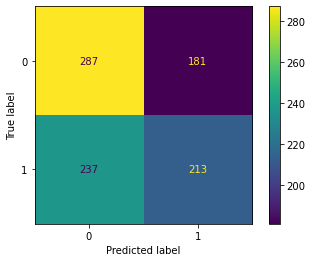

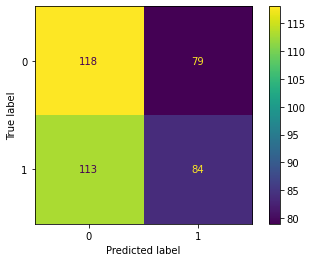

In [25]:
pipe.fit(X_train, y_train)
log_preds=pipe.predict(X_test)

print(classification_report(y_test,log_preds))

print(scores_news(pipe, y_test))

In [26]:
pipe_RF=Pipeline([('sd', StandardScaler()),('RF_clf', RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 1150,))])
#fitting the model
pipe_RF.fit(X_train, y_train)
rf_preds=pipe_RF.predict(X_test)

print(classification_report(y_test,rf_preds))

              precision    recall  f1-score   support

           0       0.51      0.53      0.52       197
           1       0.51      0.48      0.49       197

    accuracy                           0.51       394
   macro avg       0.51      0.51      0.51       394
weighted avg       0.51      0.51      0.51       394



In [27]:
## Takes around 15 minsb

# # let's run a gridsearch on this model
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#                'RF_clf__n_estimators': [200, 500,1000, 2000],
#                'RF_clf__criterion' :['gini','entropy'],
#                'RF_clf__max_depth': [3,5,8],
#                'RF_clf__max_features' : [5,10,13]
               
#              }


# gs = GridSearchCV(pipe_RF, 
#                   param_grid, 
#                   cv=5,
#                   verbose = 2
#                  )
# rf_gs_results= gs.fit(X_train,y_train)

In [28]:
# rf_gs_results.best_score_


In [29]:
# rf_gs_results.best_params_

In [30]:

param_grid_log = {
               'log_clf__penalty': ['l1', 'l2'],
               'log_clf__solver' :['liblinear','saga'],
               'log_clf__max_iter': [40,50,100,200,300,500,1000],
               
               
             }

gs = GridSearchCV(pipe, 
                  param_grid_log, 
                  cv=5,
                  verbose = 2
                 )
log_gs_results = gs.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=40, log_clf__penalty=l1, log_clf__solver=saga .
[CV]  log_clf__max_iter=40, log_clf__penal

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  log_clf__max_iter=50, log_clf__penalty=l1, log_clf__solver=saga, total=   0.0s
[CV] log_clf__max_iter=50, log_clf__penalty=l1, log_clf__solver=saga .
[CV]  log_clf__max_iter=50, log_clf__penalty=l1, log_clf__solver=saga, total=   0.0s
[CV] log_clf__max_iter=50, log_clf__penalty=l1, log_clf__solver=saga .
[CV]  log_clf__max_iter=50, log_clf__penalty=l1, log_clf__solver=saga, total=   0.0s
[CV] log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=50, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=50, log_c

[CV]  log_clf__max_iter=300, log_clf__penalty=l1, log_clf__solver=saga, total=   0.0s
[CV] log_clf__max_iter=300, log_clf__penalty=l1, log_clf__solver=saga 
[CV]  log_clf__max_iter=300, log_clf__penalty=l1, log_clf__solver=saga, total=   0.0s
[CV] log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear, total=   0.0s
[CV] log_clf__max_iter=300, log_clf__penalty=l2, log_clf__solver=liblinear 
[CV]  log_clf

[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.9s finished


In [31]:
log_gs_results.best_score_

0.49792706105963414

In [32]:
## Naive Bayes
from sklearn.naive_bayes import GaussianNB
NB_clf=Pipeline([('sd', StandardScaler()),('NB_clf', GaussianNB())])

NB_clf.fit(X_train, y_train)

nb_preds = NB_clf.predict(X_test)


print(classification_report(y_test,nb_preds))

              precision    recall  f1-score   support

           0       0.51      0.87      0.64       197
           1       0.54      0.15      0.23       197

    accuracy                           0.51       394
   macro avg       0.52      0.51      0.44       394
weighted avg       0.52      0.51      0.44       394



Train Scores
log loss:  15.99023087327887
accuracy:  0.5370370370370371
precision: 0.5806451612903226
recall:    0.2
Test Scores
log loss:  16.918791457242428
accuracy:  0.5101522842639594
precision: 0.5370370370370371
recall:    0.14720812182741116


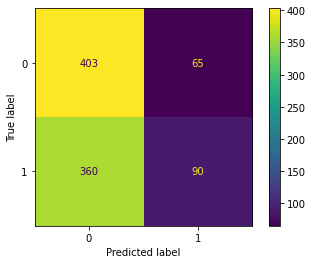

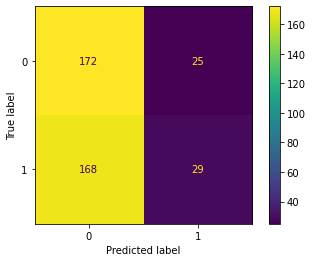

In [33]:
scores_news(NB_clf, y_test)

In [34]:
## a few more models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

## Initial the pipelines for new models
XGB_clf=Pipeline([('sd', StandardScaler()),('XGB_clf', XGBClassifier(random_state=42, objective='binary:logistic', alpha=2))])
GB_clf=Pipeline([('sd', StandardScaler()),('GB_clf', GradientBoostingClassifier(random_state=42))])



In [35]:
#Random Forest

pipe_RF.fit(X_train, y_train)
rf_preds_news= pipe_RF.predict(X_test)

# XGBoost
XGB_clf.fit(X_train, y_train)
XGB_preds_news= XGB_clf.predict(X_test)

# Gradient Boost
GB_clf.fit(X_train, y_train)
GB_preds_news= GB_clf.predict(X_test)

Train Scores
log loss:  9.992007221626413e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  17.181919124767415
accuracy:  0.5025380710659898
precision: 0.5026178010471204
recall:    0.4873096446700508


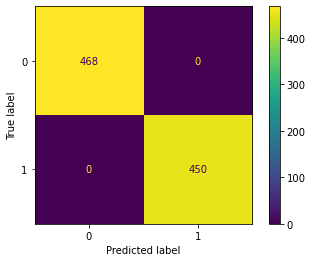

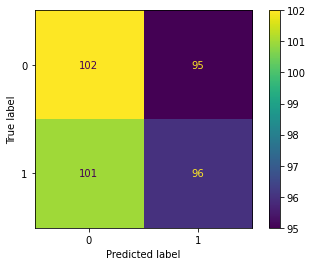

In [36]:
scores_news(pipe_RF, y_test)

Train Scores
log loss:  9.992007221626413e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  16.042304680297896
accuracy:  0.5355329949238579
precision: 0.5360824742268041
recall:    0.5279187817258884


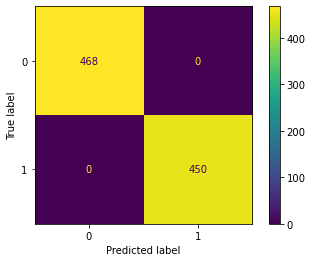

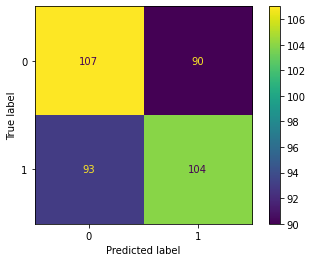

In [37]:
scores_news(XGB_clf, y_test)

Train Scores
log loss:  3.2356910185917607
accuracy:  0.906318082788671
precision: 0.9155251141552512
recall:    0.8911111111111111
Test Scores
log loss:  14.639704628760533
accuracy:  0.5761421319796954
precision: 0.575
recall:    0.583756345177665


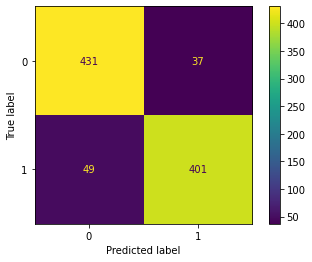

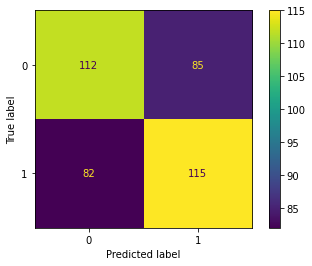

In [38]:
scores_news(GB_clf, y_test)

## Feature Importances and drop some features

In [39]:
# Lets drop some features from the model to make it better for news paper
def plot_feature_importance_news(model):
    name=model.steps[1][0]
    X_var=model.steps[1][1].feature_importances_
    y_var=X_train.columns
    sns.barplot(x=X_var, y= y_var)
    plt.title("News Feature Importance %s" %name)

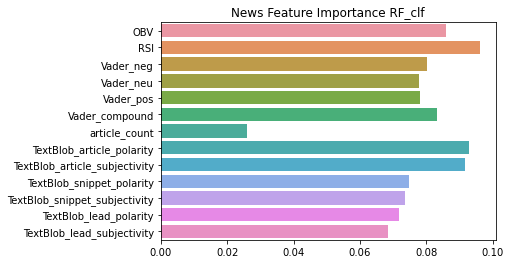

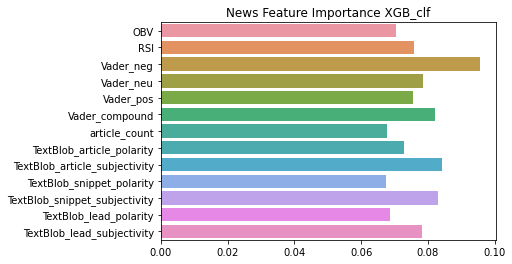

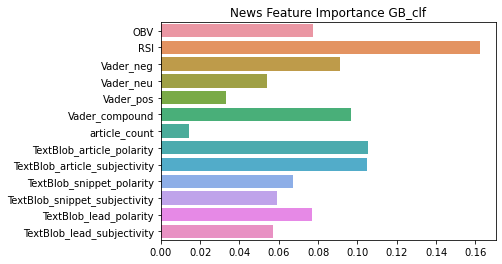

In [40]:
## Lets pick 5 features out of these

models= [pipe_RF, XGB_clf, GB_clf]

# 
for model in models:    
    plot_feature_importance_news(model)
    plt.show()

In [41]:
## I have selected the 5 features that seems to overlap and be most important from the graphs above

select_features_news=['RSI','Vader_neg','Vader_compound', 'TextBlob_article_subjectivity', 'TextBlob_article_polarity']
X1=df_TSLA_Senti[select_features_news]
y1=df_TSLA_Senti['Green']
X_train_news_f, X_test_news_f, y_train_news_f, y_test_news_f = train_test_split(X1, y1, test_size = 0.3, random_state=42)

In [42]:
### reinitiate this for the new trains

def scores_news(model, actual = y_test_news_f  ,X_train_scaled = X_train_news_f, X_test_scaled = X_test_news_f ,y_train = y_train_news_f):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    plot_confusion_matrix(model, X_train_scaled, y_train)
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

In [43]:
## RUN all the models

## LOG

pipe.fit(X_train_news_f, y_train_news_f)
log_preds_news=pipe.predict(X_test_news_f)

# NAive Bayes
NB_clf.fit(X_train_news_f, y_train_news_f)
nb_preds = NB_clf.predict(X_test_news_f)

#Random Forest

pipe_RF.fit(X_train_news_f, y_train_news_f)
rf_preds_news= pipe_RF.predict(X_test_news_f)

# XGBoost
XGB_clf.fit(X_train_news_f, y_train_news_f)
XGB_preds_news= XGB_clf.predict(X_test_news_f)

# Gradient Boost
GB_clf.fit(X_train_news_f, y_train_news_f)
GB_preds_news= GB_clf.predict(X_test_news_f)

## News Scores

Train Scores
log loss:  16.291279005078703
accuracy:  0.528322440087146
precision: 0.5306859205776173
recall:    0.32666666666666666
Test Scores
log loss:  17.35715559710326
accuracy:  0.49746192893401014
precision: 0.49514563106796117
recall:    0.25888324873096447


              precision    recall  f1-score   support

           0       0.50      0.74      0.59       197
           1       0.50      0.26      0.34       197

    accuracy                           0.50       394
   macro avg       0.50      0.50      0.47       394
weighted avg       0.50      0.50      0.47       394



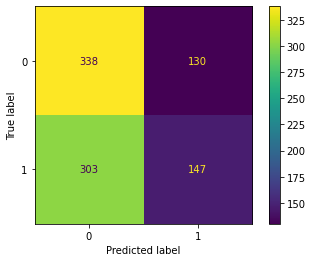

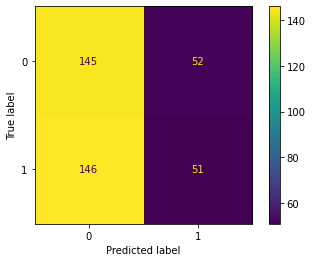

In [44]:
scores_news(pipe, y_test_news_f)
print('\n')
print(classification_report(y_test_news_f,log_preds_news))

Train Scores
log loss:  16.366443265902802
accuracy:  0.5261437908496732
precision: 0.5903614457831325
recall:    0.10888888888888888
Test Scores
log loss:  17.444746435897308
accuracy:  0.4949238578680203
precision: 0.46875
recall:    0.07614213197969544


              precision    recall  f1-score   support

           0       0.50      0.91      0.64       197
           1       0.47      0.08      0.13       197

    accuracy                           0.49       394
   macro avg       0.48      0.49      0.39       394
weighted avg       0.48      0.49      0.39       394



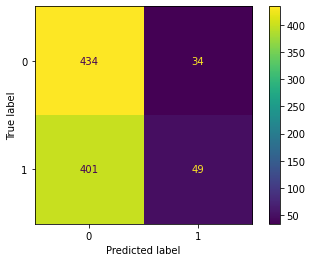

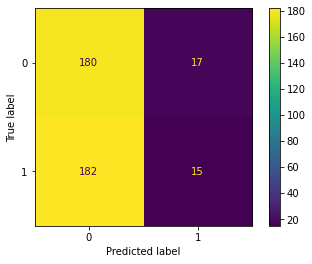

In [45]:
scores_news(NB_clf, y_test_news_f)
print('\n')
print(classification_report(y_test_news_f,nb_preds))

Train Scores
log loss:  9.992007221626413e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  16.655925586845598
accuracy:  0.5177664974619289
precision: 0.52
recall:    0.4619289340101523


              precision    recall  f1-score   support

           0       0.52      0.57      0.54       197
           1       0.52      0.46      0.49       197

    accuracy                           0.52       394
   macro avg       0.52      0.52      0.52       394
weighted avg       0.52      0.52      0.52       394



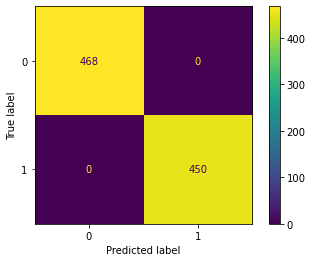

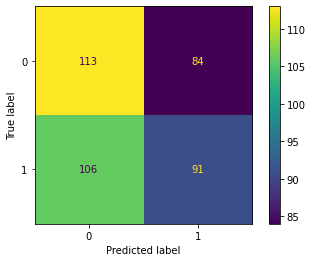

In [46]:
## Overfit
scores_news(pipe_RF, y_test_news_f)
print('\n')
print(classification_report(y_test_news_f,rf_preds_news))

Train Scores
log loss:  0.5267412491402633
accuracy:  0.9847494553376906
precision: 0.9844444444444445
recall:    0.9844444444444445
Test Scores
log loss:  17.444894584659757
accuracy:  0.4949238578680203
precision: 0.4943820224719101
recall:    0.4467005076142132


              precision    recall  f1-score   support

           0       0.50      0.54      0.52       197
           1       0.49      0.45      0.47       197

    accuracy                           0.49       394
   macro avg       0.49      0.49      0.49       394
weighted avg       0.49      0.49      0.49       394



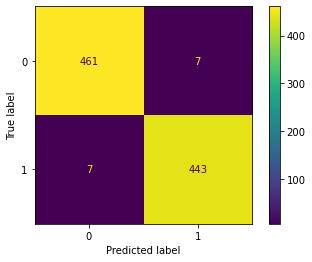

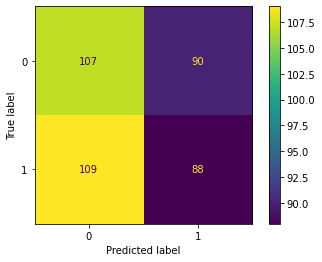

In [47]:
# OVerfit
scores_news(XGB_clf, y_test_news_f)
print('\n')
print(classification_report(y_test_news_f, XGB_preds_news))

In [48]:
from sklearn import svm 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

In [49]:
poly_svm_clf= Pipeline([('poly_features', PolynomialFeatures(degree=3)),
                        ('sd', StandardScaler()),
                        ('svm_clf', LinearSVC(C=5, loss='hinge',max_iter=1000000))])
poly_svm_clf.fit(X_train_news_f, y_train_news_f)

svm_preds_news = poly_svm_clf.predict(X_test_news_f)

Train Scores
log loss:  14.598229603495682
accuracy:  0.5773420479302832
precision: 0.5803108808290155
recall:    0.49777777777777776
Test Scores
log loss:  17.532536159331347
accuracy:  0.49238578680203043
precision: 0.49044585987261147
recall:    0.39086294416243655


              precision    recall  f1-score   support

           0       0.49      0.59      0.54       197
           1       0.49      0.39      0.44       197

    accuracy                           0.49       394
   macro avg       0.49      0.49      0.49       394
weighted avg       0.49      0.49      0.49       394



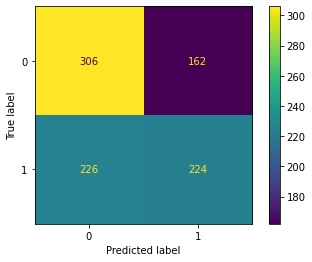

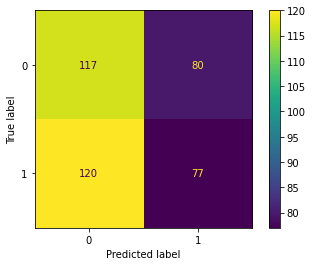

In [50]:
scores_news(poly_svm_clf, y_test_news_f)
print('\n')
print(classification_report(y_test_news_f, svm_preds_news))

## Elon Musk Tweets

In [51]:
tesla_tweets = pd.read_csv('elonmusk.csv')

tesla_tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [52]:
#clean the data set, let's get rid of everything besides date, tweet, replies_count, retweets_count, likes_count, 

tesla_tweets.drop(['id', 'conversation_id', 'created_at', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'mentions', 'urls',
       'photos', 'replies_count',  'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],1, inplace=True)
tesla_tweets

,date,tweet,retweets_count,likes_count
0,2020-07-14,Cute,176,7883
1,2020-07-14,Wow,180,4241
2,2020-07-13,Reusability is essential. A rocket that is sin...,126,1551
3,2020-07-13,Wild times!,415,13421
4,2020-07-13,We’re being extra paranoid. Maximizing probabi...,155,4238
...,...,...,...,...
9281,2015-02-08,Prob good though. Will give us time to replace...,452,940
9282,2015-02-08,Air Force tracking radar went down. Launch pos...,1479,1147
9283,2015-02-08,Rocket reentry will be much tougher this time ...,1154,2176
9284,2015-02-08,Launching our 1st deep space mission today. He...,3026,4198


In [53]:
tesla_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9286 entries, 0 to 9285
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            9286 non-null   object
 1   tweet           9286 non-null   object
 2   retweets_count  9286 non-null   int64 
 3   likes_count     9286 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 290.3+ KB


In [54]:
# lets update these tweets with the VADER polaroty scores
SI= SentimentIntensityAnalyzer()
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(tesla_tweets['tweet'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = SI.polarity_scores(tesla_tweets['tweet'][i])["compound"]
    pos = SI.polarity_scores(tesla_tweets['tweet'][i])["pos"]
    neu = SI.polarity_scores(tesla_tweets['tweet'][i])["neu"]
    neg = SI.polarity_scores(tesla_tweets['tweet'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })


In [55]:
tesla_tweets['sentiment']=scores
tesla_tweets

,date,tweet,retweets_count,likes_count,sentiment
0,2020-07-14,Cute,176,7883,"{'Compound': 0.4588, 'Positive': 1.0, 'Negativ..."
1,2020-07-14,Wow,180,4241,"{'Compound': 0.5859, 'Positive': 1.0, 'Negativ..."
2,2020-07-13,Reusability is essential. A rocket that is sin...,126,1551,"{'Compound': -0.34, 'Positive': 0.0, 'Negative..."
3,2020-07-13,Wild times!,415,13421,"{'Compound': 0.0, 'Positive': 0.0, 'Negative':..."
4,2020-07-13,We’re being extra paranoid. Maximizing probabi...,155,4238,"{'Compound': 0.4215, 'Positive': 0.257, 'Negat..."
...,...,...,...,...,...
9281,2015-02-08,Prob good though. Will give us time to replace...,452,940,"{'Compound': 0.6858, 'Positive': 0.229, 'Negat..."
9282,2015-02-08,Air Force tracking radar went down. Launch pos...,1479,1147,"{'Compound': -0.2023, 'Positive': 0.0, 'Negati..."
9283,2015-02-08,Rocket reentry will be much tougher this time ...,1154,2176,"{'Compound': 0.1779, 'Positive': 0.066, 'Negat..."
9284,2015-02-08,Launching our 1st deep space mission today. He...,3026,4198,"{'Compound': 0.0, 'Positive': 0.0, 'Negative':..."


In [56]:
## explode out the dictionary into its own columns

df3 = pd.json_normalize(tesla_tweets['sentiment'])
df3 = pd.DataFrame(df3)

tesla_tweets= pd.concat([df3, tesla_tweets],1)
tesla_tweets

,Compound,Positive,Negative,Neutral,date,tweet,retweets_count,likes_count,sentiment
0,0.4588,1.000,0.000,0.000,2020-07-14,Cute,176,7883,"{'Compound': 0.4588, 'Positive': 1.0, 'Negativ..."
1,0.5859,1.000,0.000,0.000,2020-07-14,Wow,180,4241,"{'Compound': 0.5859, 'Positive': 1.0, 'Negativ..."
2,-0.3400,0.000,0.098,0.902,2020-07-13,Reusability is essential. A rocket that is sin...,126,1551,"{'Compound': -0.34, 'Positive': 0.0, 'Negative..."
3,0.0000,0.000,0.000,1.000,2020-07-13,Wild times!,415,13421,"{'Compound': 0.0, 'Positive': 0.0, 'Negative':..."
4,0.4215,0.257,0.135,0.608,2020-07-13,We’re being extra paranoid. Maximizing probabi...,155,4238,"{'Compound': 0.4215, 'Positive': 0.257, 'Negat..."
...,...,...,...,...,...,...,...,...,...
9281,0.6858,0.229,0.000,0.771,2015-02-08,Prob good though. Will give us time to replace...,452,940,"{'Compound': 0.6858, 'Positive': 0.229, 'Negat..."
9282,-0.2023,0.000,0.141,0.859,2015-02-08,Air Force tracking radar went down. Launch pos...,1479,1147,"{'Compound': -0.2023, 'Positive': 0.0, 'Negati..."
9283,0.1779,0.066,0.000,0.934,2015-02-08,Rocket reentry will be much tougher this time ...,1154,2176,"{'Compound': 0.1779, 'Positive': 0.066, 'Negat..."
9284,0.0000,0.000,0.000,1.000,2015-02-08,Launching our 1st deep space mission today. He...,3026,4198,"{'Compound': 0.0, 'Positive': 0.0, 'Negative':..."


In [57]:
tesla_tweets.drop(['tweet','sentiment'],1 , inplace=True)

In [58]:
tesla_tweets

,Compound,Positive,Negative,Neutral,date,retweets_count,likes_count
0,0.4588,1.000,0.000,0.000,2020-07-14,176,7883
1,0.5859,1.000,0.000,0.000,2020-07-14,180,4241
2,-0.3400,0.000,0.098,0.902,2020-07-13,126,1551
3,0.0000,0.000,0.000,1.000,2020-07-13,415,13421
4,0.4215,0.257,0.135,0.608,2020-07-13,155,4238
...,...,...,...,...,...,...,...
9281,0.6858,0.229,0.000,0.771,2015-02-08,452,940
9282,-0.2023,0.000,0.141,0.859,2015-02-08,1479,1147
9283,0.1779,0.066,0.000,0.934,2015-02-08,1154,2176
9284,0.0000,0.000,0.000,1.000,2015-02-08,3026,4198


In [59]:
#lets aggregative the days with 
tweet_counts= tesla_tweets.groupby('date').mean()


In [60]:
tweet_counts

,Compound,Positive,Negative,Neutral,retweets_count,likes_count
date,,,,,,
2015-01-30,0.318200,0.150000,0.000000,0.850000,462.000000,796.000000
2015-02-08,0.165350,0.073750,0.035250,0.891000,1527.750000,2115.250000
2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667
2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000
2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000
...,...,...,...,...,...,...
2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455
2020-07-11,0.114700,0.250000,0.000000,0.750000,3255.000000,64089.750000
2020-07-12,0.339633,0.472667,0.120667,0.406667,85.000000,4840.000000


In [61]:
# tesla_tweets['date']=pd.to_datetime(tesla_tweets['date'])
tesla_counts= tesla_tweets.groupby('date').mean()

tweet_counts['count']=1
# tesla_tweets.set_index('date',inplace= True)
t=tweet_counts.groupby('date')['count'].count().to_frame()
t

tesla_tweets_final= tweet_counts.merge(t, how='inner', left_on = 'date', right_on = 'date')
tesla_tweets_final

,Compound,Positive,Negative,Neutral,retweets_count,likes_count,count_x,count_y
date,,,,,,,,
2015-01-30,0.318200,0.150000,0.000000,0.850000,462.000000,796.000000,1,1
2015-02-08,0.165350,0.073750,0.035250,0.891000,1527.750000,2115.250000,1,1
2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1,1
2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,1,1
2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,1,1
...,...,...,...,...,...,...,...,...
2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,1,1
2020-07-11,0.114700,0.250000,0.000000,0.750000,3255.000000,64089.750000,1,1
2020-07-12,0.339633,0.472667,0.120667,0.406667,85.000000,4840.000000,1,1


In [62]:
# drop unecessary cols
tesla_tweets_final.drop([ 'count_x'], 1, inplace=True)
tesla_tweets_final.rename(columns={'count_y':'daily_tweet_count', 'Compound' : 'Tweet_compound_score', 
                                   'Positive' : 'Tweet_positive_score', 
                                   'Negative': 'Tweet_negative_score', 
                                   'Neutral' :'Tweet_neutral_score'}, inplace=True)
tesla_tweets_final

,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,daily_tweet_count
date,,,,,,,
2015-01-30,0.318200,0.150000,0.000000,0.850000,462.000000,796.000000,1
2015-02-08,0.165350,0.073750,0.035250,0.891000,1527.750000,2115.250000,1
2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1
2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,1
2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,1
...,...,...,...,...,...,...,...
2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,1
2020-07-11,0.114700,0.250000,0.000000,0.750000,3255.000000,64089.750000,1
2020-07-12,0.339633,0.472667,0.120667,0.406667,85.000000,4840.000000,1


In [63]:
tesla_stock_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,08/30/2021,730.91,18604220,714.715,731.00,712.7300
1,08/27/2021,711.92,13833760,705.000,715.00,702.1001
2,08/26/2021,701.16,13214290,708.310,715.40,697.6201
3,08/25/2021,711.20,12645560,707.030,716.97,704.0000
4,08/24/2021,708.49,13083070,710.680,715.22,702.6400


In [64]:
tesla_tweets_final.head()

,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,daily_tweet_count
date,,,,,,,
2015-01-30,0.318200,0.150000,0.00000,0.850000,462.000000,796.000000,1
2015-02-08,0.165350,0.073750,0.03525,0.891000,1527.750000,2115.250000,1
2015-02-10,0.181967,0.087000,0.02300,0.890000,526.666667,773.666667,1
2015-02-11,0.275738,0.109625,0.00725,0.883125,1361.625000,2531.750000,1
2015-02-12,0.000000,0.000000,0.00000,1.000000,1467.000000,2660.000000,1


In [65]:
tesla_stock_df['Date'] = pd.to_datetime(tesla_stock_df['Date'], format= "%m/%d/%Y")

In [66]:
tesla_stock_df

,Date,Close/Last,Volume,Open,High,Low
0,2021-08-30,730.910,18604220,714.715,731.000,712.7300
1,2021-08-27,711.920,13833760,705.000,715.000,702.1001
2,2021-08-26,701.160,13214290,708.310,715.400,697.6201
3,2021-08-25,711.200,12645560,707.030,716.970,704.0000
4,2021-08-24,708.490,13083070,710.680,715.220,702.6400
...,...,...,...,...,...,...
2511,2011-09-07,4.768,2295930,4.678,4.800,4.6560
2512,2011-09-06,4.588,4048800,4.500,4.640,4.4580
2513,2011-09-02,4.614,3849155,4.732,4.798,4.5360
2514,2011-09-01,4.800,4240425,4.932,4.974,4.7670


In [67]:
tesla_tweets_final.index= pd.to_datetime(tesla_tweets_final.index)

In [68]:
#set a date time so can merge
# df_tweets_clean['date']=pd.to_datetime(df_tweets_clean['date'])

## combine the dataframe together

tesla_stock_df['Date'] =  pd.to_datetime(tesla_stock_df['Date'])
df_tweets_clean= tesla_stock_df.merge(tesla_tweets_final, how='inner', left_on= "Date", right_on='date')


df_tweets_clean

,Date,Close/Last,Volume,Open,High,Low,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,daily_tweet_count
0,2020-07-14,303.360,117090700,311.200,318.0000,286.200,0.522350,1.000000,0.000000,0.000000,178.000000,6062.000000,1
1,2020-07-13,299.412,194926800,331.800,358.9980,294.222,0.164587,0.216067,0.098333,0.618933,196.266667,5705.333333,1
2,2020-07-10,308.930,116687750,279.200,309.7830,275.202,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,1
3,2020-07-09,278.856,58588000,279.398,281.7120,270.256,0.062012,0.278250,0.100125,0.621625,1674.750000,30163.875000,1
4,2020-07-08,273.176,81556550,281.000,283.4520,262.268,0.149550,0.261500,0.147000,0.591500,1816.000000,23619.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2015-02-24,40.822,32936490,41.458,41.4580,40.340,0.636900,0.219000,0.000000,0.781000,1668.000000,2101.000000,1
944,2015-02-12,40.576,78134150,38.714,40.6176,38.656,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,1
945,2015-02-11,42.560,45265415,42.442,42.9480,41.456,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,1
946,2015-02-10,43.258,26744310,43.510,44.1000,43.000,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1


In [69]:
df_tweets_clean['Day_Net']= df_tweets_clean['Open']-df_tweets_clean['Close/Last']
df_tweets_clean['Green']= np.where(df_tweets_clean['Day_Net']>0,1,0)
df_tweets_clean=df_tweets_clean.drop(['Close/Last', 'Volume', 'Open', 'High', 'Low','Day_Net','daily_tweet_count'],1)

In [70]:
df_tweets_clean

,Date,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,Green
0,2020-07-14,0.522350,1.000000,0.000000,0.000000,178.000000,6062.000000,1
1,2020-07-13,0.164587,0.216067,0.098333,0.618933,196.266667,5705.333333,1
2,2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,0
3,2020-07-09,0.062012,0.278250,0.100125,0.621625,1674.750000,30163.875000,1
4,2020-07-08,0.149550,0.261500,0.147000,0.591500,1816.000000,23619.000000,1
...,...,...,...,...,...,...,...,...
943,2015-02-24,0.636900,0.219000,0.000000,0.781000,1668.000000,2101.000000,1
944,2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,0
945,2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,0
946,2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1


### Let's Run Some models with the Tweets

In [71]:
X_tweet= df_tweets_clean.drop(['Green','Date'],1)
y_tweet=df_tweets_clean['Green']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tweet, y_tweet, test_size = 0.3, random_state=42)

In [72]:
## Adjust the scores for new train 
def scores_tweet(model, actual = y_test_t ,X_train_scaled = X_train_t, X_test_scaled = X_test_t,y_train = y_train_t):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    plot_confusion_matrix(model, X_train_scaled, y_train)
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

              precision    recall  f1-score   support

           0       0.49      0.66      0.56       143
           1       0.48      0.32      0.38       142

    accuracy                           0.49       285
   macro avg       0.49      0.49      0.47       285
weighted avg       0.49      0.49      0.47       285

Train Scores
log loss:  15.941083469394897
accuracy:  0.5384615384615384
precision: 0.542713567839196
recall:    0.33436532507739936
Test Scores
log loss:  17.693686083968558
accuracy:  0.48771929824561405
precision: 0.4787234042553192
recall:    0.31690140845070425


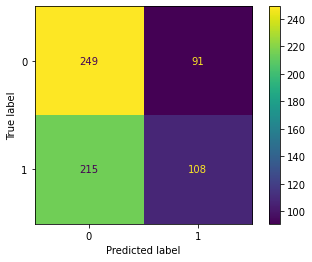

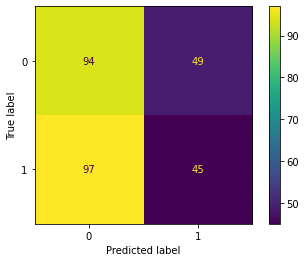

In [73]:
## Logistic
pipe.fit(X_train_t, y_train_t)
log_preds_tweets=pipe.predict(X_test_t)

print(classification_report(y_test_t,log_preds_tweets))
scores_tweet(pipe, y_test_t)

              precision    recall  f1-score   support

           0       0.49      0.50      0.49       143
           1       0.48      0.47      0.48       142

    accuracy                           0.48       285
   macro avg       0.48      0.48      0.48       285
weighted avg       0.48      0.48      0.48       285

Train Scores
log loss:  9.992007221626413e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  17.814939301988925
accuracy:  0.4842105263157895
precision: 0.48201438848920863
recall:    0.47183098591549294


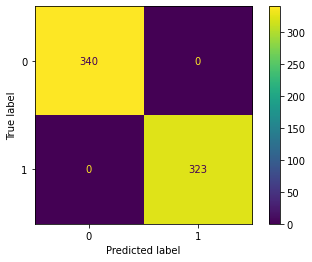

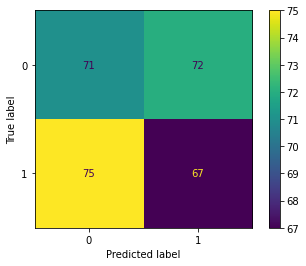

In [74]:
##Random Forest 

pipe_RF.fit(X_train_t, y_train_t)
rf_preds_tweets= pipe_RF.predict(X_test_t)


print(classification_report(y_test_t,rf_preds_tweets))
scores_tweet(pipe_RF, y_test_t)


              precision    recall  f1-score   support

           0       0.33      0.02      0.04       143
           1       0.49      0.96      0.65       142

    accuracy                           0.49       285
   macro avg       0.41      0.49      0.35       285
weighted avg       0.41      0.49      0.34       285

Train Scores
log loss:  18.181444386988268
accuracy:  0.473604826546003
precision: 0.47955974842767296
recall:    0.9442724458204335
Test Scores
log loss:  17.693941394025213
accuracy:  0.48771929824561405
precision: 0.4927536231884058
recall:    0.9577464788732394


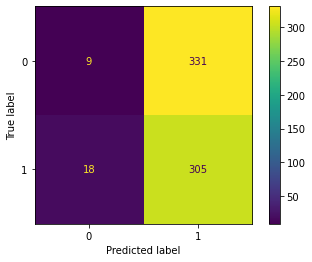

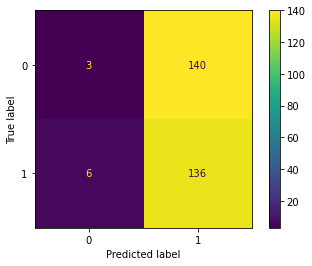

In [75]:
## Naive Bayes
NB_clf.fit(X_train_t, y_train_t)
nb_preds_tweets= NB_clf.predict(X_test_t)


print(classification_report(y_test_t,nb_preds_tweets))
scores_tweet(NB_clf, y_test_t)

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       143
           1       0.46      0.46      0.46       142

    accuracy                           0.47       285
   macro avg       0.47      0.47      0.47       285
weighted avg       0.47      0.47      0.47       285

Train Scores
log loss:  0.9898086701097211
accuracy:  0.971342383107089
precision: 0.975
recall:    0.9659442724458205
Test Scores
log loss:  18.420893969933747
accuracy:  0.4666666666666667
precision: 0.4647887323943662
recall:    0.4647887323943662


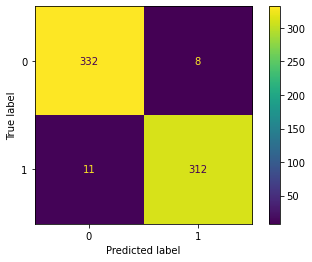

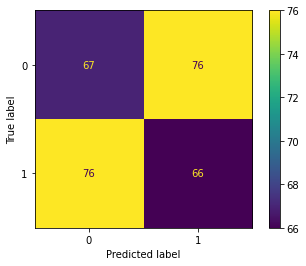

In [76]:
## XGBoost

XGB_clf.fit(X_train_t, y_train_t)
XGB_preds_tweets= XGB_clf.predict(X_test_t)


print(classification_report(y_test_t,XGB_preds_tweets))
scores_tweet(XGB_clf, y_test_t)

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       143
           1       0.48      0.44      0.46       142

    accuracy                           0.48       285
   macro avg       0.48      0.48      0.48       285
weighted avg       0.48      0.48      0.48       285

Train Scores
log loss:  3.959220208087204
accuracy:  0.8853695324283559
precision: 0.9303135888501742
recall:    0.826625386996904
Test Scores
log loss:  17.936116768673806
accuracy:  0.4807017543859649
precision: 0.47692307692307695
recall:    0.43661971830985913


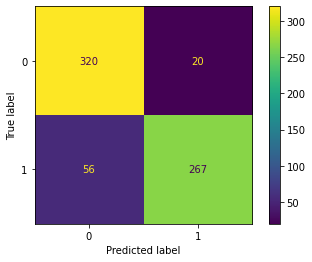

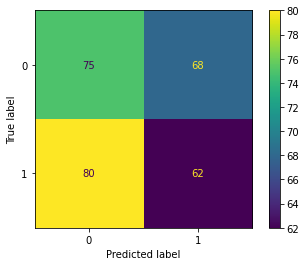

In [77]:
GB_clf.fit(X_train_t, y_train_t)
GB_preds_tweets= GB_clf.predict(X_test_t)

print(classification_report(y_test_t,GB_preds_tweets))
scores_tweet(GB_clf, y_test_t)

## Reduce some Features

In [78]:
def plot_feature_importance_tweet(model):
    name=model.steps[1][0]
    X_var=model.steps[1][1].feature_importances_
    y_var=X_train_t.columns
    sns.barplot(x=X_var, y= y_var)
    plt.title("Tweet Feature Importance %s" %name)

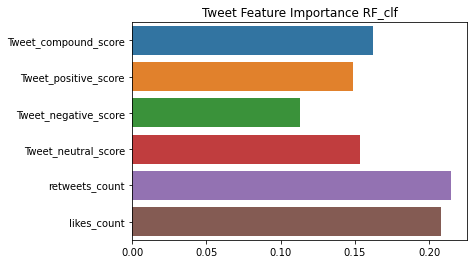

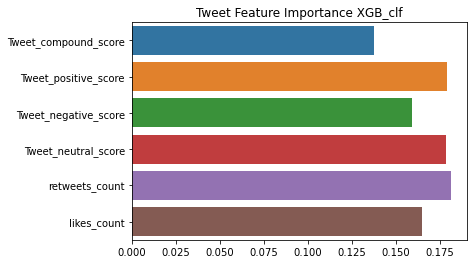

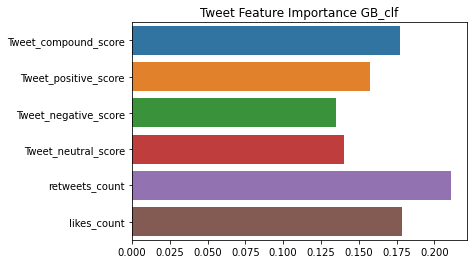

In [79]:
models= [pipe_RF, XGB_clf, GB_clf]

for model in models:    
    plot_feature_importance_tweet(model)
    plt.show()

In [80]:
df_tweets_clean

,Date,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,Green
0,2020-07-14,0.522350,1.000000,0.000000,0.000000,178.000000,6062.000000,1
1,2020-07-13,0.164587,0.216067,0.098333,0.618933,196.266667,5705.333333,1
2,2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,0
3,2020-07-09,0.062012,0.278250,0.100125,0.621625,1674.750000,30163.875000,1
4,2020-07-08,0.149550,0.261500,0.147000,0.591500,1816.000000,23619.000000,1
...,...,...,...,...,...,...,...,...
943,2015-02-24,0.636900,0.219000,0.000000,0.781000,1668.000000,2101.000000,1
944,2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,0
945,2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,0
946,2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1


OBV is too correlated to price so we must drop it

In [81]:
## Rerun these tweet models with The most important features:

X_tweet_most_feats= df_tweets_clean.drop(['Green','Date','Tweet_positive_score','retweets_count', 'Tweet_negative_score', 'Tweet_neutral_score','likes_count' ],1)
y_tweet_most_feats=df_tweets_clean['Green']

X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(X_tweet_most_feats, y_tweet_most_feats, test_size = 0.3, random_state=42)

In [82]:
# need to re-run this so that train data updates
def scores_tweet(model, actual = y_test_t2 ,X_train_scaled = X_train_t2, X_test_scaled = X_test_t2 ,y_train = y_train_t2):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    plot_confusion_matrix(model, X_train_scaled, y_train)
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

In [83]:
## all models

#logistic
pipe.fit(X_train_t2, y_train_t2)
log_preds_tweets=pipe.predict(X_test_t2)

## Naive Bayes
NB_clf.fit(X_train_t2, y_train_t2)
nb_preds_tweets= NB_clf.predict(X_test_t2)

#Random Forest

pipe_RF.fit(X_train_t2, y_train_t2)
rf_preds_tweets= pipe_RF.predict(X_test_t2)

# XGBoost
XGB_clf.fit(X_train_t2, y_train_t2)
XGB_preds_tweets= XGB_clf.predict(X_test_t2)

# Gradient Boost
GB_clf.fit(X_train_t2, y_train_t2)
GB_preds_tweets= GB_clf.predict(X_test_t2)

Train Scores
log loss:  16.618207042490752
accuracy:  0.5188536953242836
precision: 0.75
recall:    0.018575851393188854
Test Scores
log loss:  17.693562637347753
accuracy:  0.48771929824561405
precision: 0.16666666666666666
recall:    0.007042253521126761


              precision    recall  f1-score   support

           0       0.49      0.97      0.65       143
           1       0.17      0.01      0.01       142

    accuracy                           0.49       285
   macro avg       0.33      0.49      0.33       285
weighted avg       0.33      0.49      0.33       285



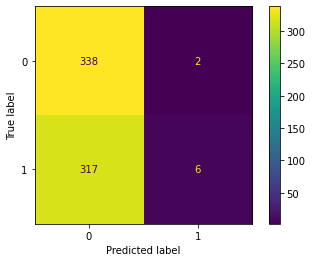

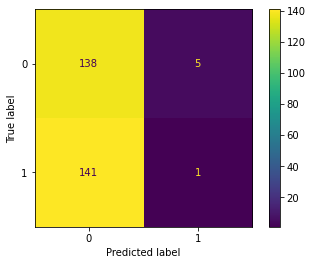

In [84]:
# Log

scores_tweet(pipe, y_test_t)
print('\n')
print(classification_report(y_test_t,log_preds_tweets))


Train Scores
log loss:  16.774528485484822
accuracy:  0.5143288084464555
precision: 0.5074626865671642
recall:    0.10526315789473684
Test Scores
log loss:  17.208838742583158
accuracy:  0.5017543859649123
precision: 0.5
recall:    0.11267605633802817


              precision    recall  f1-score   support

           0       0.50      0.89      0.64       143
           1       0.50      0.11      0.18       142

    accuracy                           0.50       285
   macro avg       0.50      0.50      0.41       285
weighted avg       0.50      0.50      0.41       285



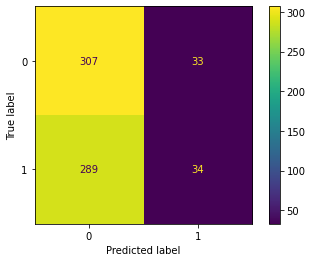

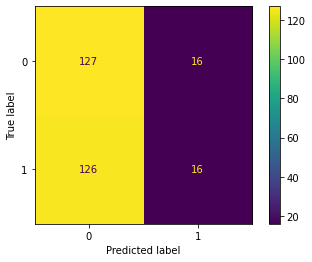

In [85]:
# NB
scores_tweet(NB_clf, y_test_t)
print('\n')
print(classification_report(y_test_t,nb_preds_tweets))

Train Scores
log loss:  2.604741504268651
accuracy:  0.9245852187028658
precision: 0.9789473684210527
recall:    0.8637770897832817
Test Scores
log loss:  16.845415761124237
accuracy:  0.512280701754386
precision: 0.5109489051094891
recall:    0.49295774647887325


              precision    recall  f1-score   support

           0       0.51      0.53      0.52       143
           1       0.51      0.49      0.50       142

    accuracy                           0.51       285
   macro avg       0.51      0.51      0.51       285
weighted avg       0.51      0.51      0.51       285



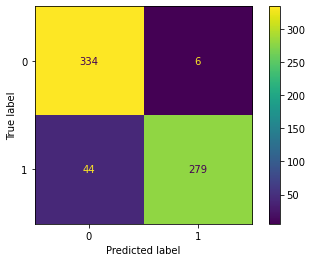

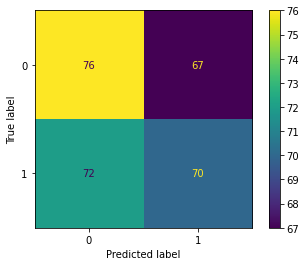

In [86]:
## RF
scores_tweet(pipe_RF, y_test_t)
print('\n')
print(classification_report(y_test_t,rf_preds_tweets))

Train Scores
log loss:  12.033962770786777
accuracy:  0.6515837104072398
precision: 0.6900826446280992
recall:    0.5170278637770898
Test Scores
log loss:  17.69370291759867
accuracy:  0.48771929824561405
precision: 0.4811320754716981
recall:    0.3591549295774648


              precision    recall  f1-score   support

           0       0.49      0.62      0.55       143
           1       0.48      0.36      0.41       142

    accuracy                           0.49       285
   macro avg       0.49      0.49      0.48       285
weighted avg       0.49      0.49      0.48       285



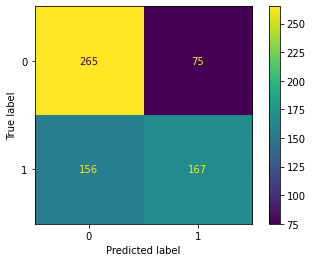

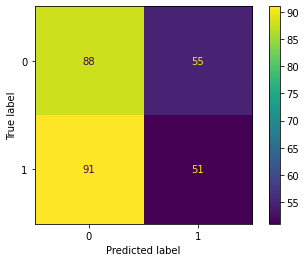

In [87]:
scores_tweet(XGB_clf, y_test_t)
print('\n')
print(classification_report(y_test_t,XGB_preds_tweets))

Train Scores
log loss:  8.647779277562766
accuracy:  0.7496229260935143
precision: 0.803088803088803
recall:    0.6439628482972136
Test Scores
log loss:  18.05728020733359
accuracy:  0.47719298245614034
precision: 0.46846846846846846
recall:    0.36619718309859156


              precision    recall  f1-score   support

           0       0.48      0.59      0.53       143
           1       0.47      0.37      0.41       142

    accuracy                           0.48       285
   macro avg       0.48      0.48      0.47       285
weighted avg       0.48      0.48      0.47       285



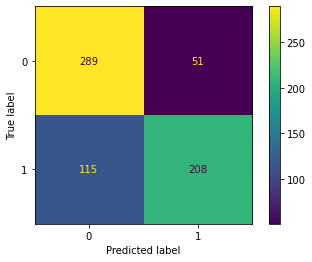

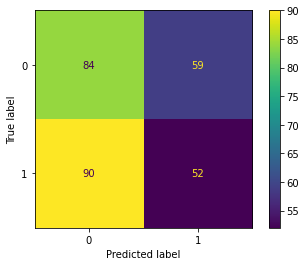

In [88]:
scores_tweet(GB_clf, y_test_t)
print('\n')
print(classification_report(y_test_t,GB_preds_tweets))

In [89]:
## Dropping features seemed to help

I still want to include some sort of price metric but one that is way less correlated. Lets try to incorporate the NASDAQ Movement

In [90]:
df_nsdaq= pd.read_csv('NASDAQ.csv')

In [91]:
df_nsdaq


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
1,2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2,2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
3,2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
4,2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000
...,...,...,...,...,...,...,...
2939,2021-09-07,15375.980469,15403.440430,15343.280273,15374.330078,15374.330078,3967040000
2940,2021-09-08,15360.349609,15360.349609,15206.610352,15286.639648,15286.639648,4113530000
2941,2021-09-09,15296.059570,15352.379883,15245.169922,15248.250000,15248.250000,3997250000
2942,2021-09-10,15332.919922,15349.469727,15111.309570,15115.490234,15115.490234,4567980000


In [92]:

df_nsdaq['Day_Net']= df_nsdaq['Open']-df_nsdaq['Close']
df_nsdaq['Movement']= np.where(df_nsdaq['Day_Net']>0,1,0)

In [93]:
df_nsdaq.drop(['Open','High', 'Low', 'Close','Adj Close', 'Volume', 'Day_Net'], 1, inplace=True)

In [94]:
df_nsdaq.Date

0       2010-01-04
1       2010-01-05
2       2010-01-06
3       2010-01-07
4       2010-01-08
           ...    
2939    2021-09-07
2940    2021-09-08
2941    2021-09-09
2942    2021-09-10
2943    2021-09-13
Name: Date, Length: 2944, dtype: object

In [95]:
df_tweets_clean

,Date,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,Green
0,2020-07-14,0.522350,1.000000,0.000000,0.000000,178.000000,6062.000000,1
1,2020-07-13,0.164587,0.216067,0.098333,0.618933,196.266667,5705.333333,1
2,2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,0
3,2020-07-09,0.062012,0.278250,0.100125,0.621625,1674.750000,30163.875000,1
4,2020-07-08,0.149550,0.261500,0.147000,0.591500,1816.000000,23619.000000,1
...,...,...,...,...,...,...,...,...
943,2015-02-24,0.636900,0.219000,0.000000,0.781000,1668.000000,2101.000000,1
944,2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,0
945,2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,0
946,2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1


In [96]:
df_nsdaq.Date= pd.to_datetime(df_nsdaq.Date)
df_tweets_clean2= df_tweets_clean.merge(df_nsdaq, how='inner', left_on= "Date", right_on='Date')
df_tweets_clean2.rename(columns={'Movement':'NASDAQ_MOV'})

,Date,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,Green,NASDAQ_MOV
0,2020-07-14,0.522350,1.000000,0.000000,0.000000,178.000000,6062.000000,1,0
1,2020-07-13,0.164587,0.216067,0.098333,0.618933,196.266667,5705.333333,1,1
2,2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,0,0
3,2020-07-09,0.062012,0.278250,0.100125,0.621625,1674.750000,30163.875000,1,1
4,2020-07-08,0.149550,0.261500,0.147000,0.591500,1816.000000,23619.000000,1,0
...,...,...,...,...,...,...,...,...,...
943,2015-02-24,0.636900,0.219000,0.000000,0.781000,1668.000000,2101.000000,1,0
944,2015-02-12,0.000000,0.000000,0.000000,1.000000,1467.000000,2660.000000,0,0
945,2015-02-11,0.275738,0.109625,0.007250,0.883125,1361.625000,2531.750000,0,0
946,2015-02-10,0.181967,0.087000,0.023000,0.890000,526.666667,773.666667,1,0


In [114]:
df_tweets_clean2.head()

,Date,Tweet_compound_score,Tweet_positive_score,Tweet_negative_score,Tweet_neutral_score,retweets_count,likes_count,Green,Movement
0,2020-07-14,0.522350,1.000000,0.000000,0.000000,178.000000,6062.000000,1,0
1,2020-07-13,0.164587,0.216067,0.098333,0.618933,196.266667,5705.333333,1,1
2,2020-07-10,0.267573,0.315727,0.050273,0.543045,540.772727,9638.545455,0,0
3,2020-07-09,0.062012,0.278250,0.100125,0.621625,1674.750000,30163.875000,1,1
4,2020-07-08,0.149550,0.261500,0.147000,0.591500,1816.000000,23619.000000,1,0


### Lets Re run the models with Nasdaq Movement

In [98]:
## Rerun these tweet models with The most important features:

X_tweet_most_feats= df_tweets_clean2.drop(['Green','Date','Tweet_negative_score','likes_count','Tweet_positive_score' ],1)
y_tweet_most_feats=df_tweets_clean2['Green']

X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(X_tweet_most_feats, y_tweet_most_feats, test_size = 0.3, random_state=42)

In [99]:
## all models

#logistic
pipe.fit(X_train_t2, y_train_t2)
log_preds_tweets=pipe.predict(X_test_t2)

## Naive Bayes
NB_clf.fit(X_train_t2, y_train_t2)
nb_preds_tweets= NB_clf.predict(X_test_t2)

#Random Forest

pipe_RF.fit(X_train_t2, y_train_t2)
rf_preds_tweets= pipe_RF.predict(X_test_t2)

# XGBoost
XGB_clf.fit(X_train_t2, y_train_t2)
XGB_preds_tweets= XGB_clf.predict(X_test_t2)

# Gradient Boost
GB_clf.fit(X_train_t2, y_train_t2)
GB_preds_tweets= GB_clf.predict(X_test_t2)

In [100]:
# need to re-run this so that train data updates
def scores_tweet(model, actual = y_test_t2 ,X_train_scaled = X_train_t2, X_test_scaled = X_test_t2 ,y_train = y_train_t2):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    plot_confusion_matrix(model, X_train_scaled, y_train)
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

Train Scores
log loss:  11.981895824098968
accuracy:  0.6530920060331825
precision: 0.6608996539792388
recall:    0.5913312693498453
Test Scores
log loss:  12.60375833595565
accuracy:  0.6350877192982456
precision: 0.6417910447761194
recall:    0.6056338028169014


              precision    recall  f1-score   support

           0       0.63      0.66      0.65       143
           1       0.64      0.61      0.62       142

    accuracy                           0.64       285
   macro avg       0.64      0.63      0.63       285
weighted avg       0.64      0.64      0.63       285



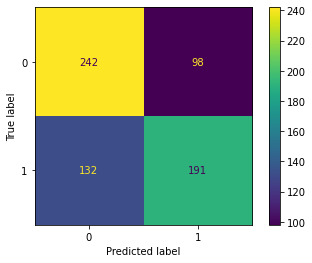

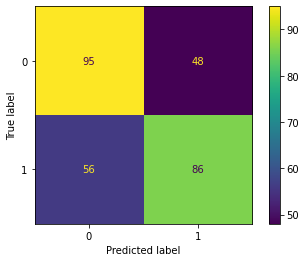

In [101]:
# Log

scores_tweet(pipe, y_test_t2)
print('\n')
print(classification_report(y_test_t2,log_preds_tweets))


Train Scores
log loss:  17.81677314725013
accuracy:  0.4841628959276018
precision: 0.4848966613672496
recall:    0.9442724458204335
Test Scores
log loss:  17.451547182185205
accuracy:  0.49473684210526314
precision: 0.49624060150375937
recall:    0.9295774647887324


              precision    recall  f1-score   support

           0       0.47      0.06      0.11       143
           1       0.50      0.93      0.65       142

    accuracy                           0.49       285
   macro avg       0.48      0.50      0.38       285
weighted avg       0.48      0.49      0.38       285



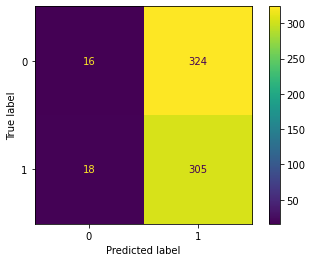

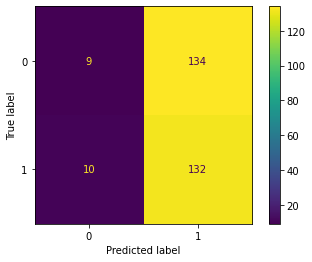

In [102]:
# NB
scores_tweet(NB_clf, y_test_t2)
print('\n')
print(classification_report(y_test_t2,nb_preds_tweets))

Train Scores
log loss:  9.992007221626413e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  12.240200685455857
accuracy:  0.6456140350877193
precision: 0.6433566433566433
recall:    0.647887323943662


              precision    recall  f1-score   support

           0       0.65      0.64      0.65       143
           1       0.64      0.65      0.65       142

    accuracy                           0.65       285
   macro avg       0.65      0.65      0.65       285
weighted avg       0.65      0.65      0.65       285



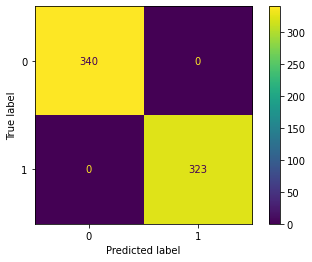

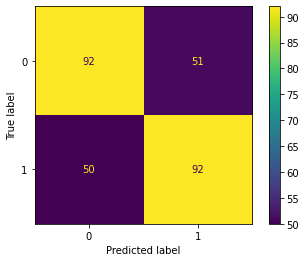

In [103]:
## RF
scores_tweet(pipe_RF, y_test_t2)
print('\n')
print(classification_report(y_test_t2,rf_preds_tweets))

Train Scores
log loss:  3.1778059578058926
accuracy:  0.9079939668174962
precision: 0.9198717948717948
recall:    0.8885448916408669
Test Scores
log loss:  13.452112826950517
accuracy:  0.6105263157894737
precision: 0.6026490066225165
recall:    0.6408450704225352


              precision    recall  f1-score   support

           0       0.62      0.58      0.60       143
           1       0.60      0.64      0.62       142

    accuracy                           0.61       285
   macro avg       0.61      0.61      0.61       285
weighted avg       0.61      0.61      0.61       285



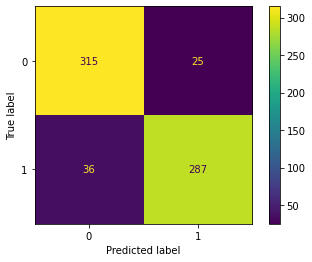

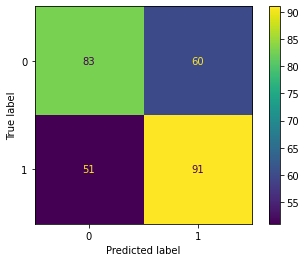

In [104]:
## XGBoost
scores_tweet(XGB_clf, y_test_t2)
print('\n')
print(classification_report(y_test_t2,XGB_preds_tweets))

Train Scores
log loss:  6.095137282773197
accuracy:  0.8235294117647058
precision: 0.8388157894736842
recall:    0.7894736842105263
Test Scores
log loss:  14.906396735445039
accuracy:  0.5684210526315789
precision: 0.5620915032679739
recall:    0.6056338028169014


              precision    recall  f1-score   support

           0       0.58      0.53      0.55       143
           1       0.56      0.61      0.58       142

    accuracy                           0.57       285
   macro avg       0.57      0.57      0.57       285
weighted avg       0.57      0.57      0.57       285



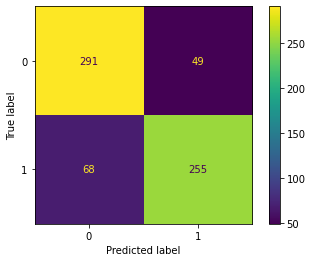

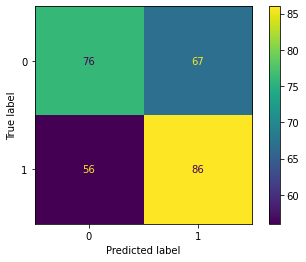

In [105]:
# GB
scores_tweet(GB_clf, y_test_t2)
print('\n')
print(classification_report(y_test_t2,GB_preds_tweets))

Many of these models seem to be overfit but we are now up to 69% accuracy

## EDA/Visualizations

<AxesSubplot:>

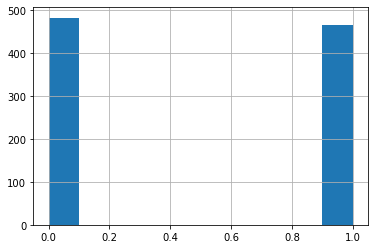

In [106]:
## NO class imbalances as I suspected

df_tweets_clean2['Green'].hist()

Let's layer in some retail trading information that I obtained from Robintrack

In [107]:
robintrack_tsla= pd.read_csv('TSLA.csv')

In [108]:
robintrack_tsla['timestamp'] = pd.to_datetime(robintrack_tsla.timestamp).dt.date
robintrack_tsla

,timestamp,users_holding
0,2018-05-02,81038
1,2018-05-02,81038
2,2018-05-03,80137
3,2018-05-03,80137
4,2018-05-03,80137
...,...,...
14949,2020-02-17,150568
14950,2020-02-17,150568
14951,2020-02-17,150568
14952,2020-02-17,150568


In [109]:
df_robintrack_tsla=robintrack_tsla.groupby('timestamp')['users_holding'].mean()
df_robintrack_tsla

timestamp
2018-05-02     81038.000000
2018-05-03     81588.473684
2018-05-04     83466.958333
2018-05-05     83239.000000
2018-05-06     83237.000000
                  ...      
2020-02-13    153695.666667
2020-02-14    150834.083333
2020-02-15    150573.375000
2020-02-16    150568.000000
2020-02-17    150568.000000
Name: users_holding, Length: 640, dtype: float64

In [110]:
tes

,Close/Last
Date,
01/02/2013,7.072
01/02/2014,30.020
01/02/2015,43.862
01/02/2018,64.106
01/02/2019,62.024
...,...
12/31/2014,44.482
12/31/2015,48.002
12/31/2018,66.560


In [111]:
tes=tes.reset_index()
# tes['Date'] = pd.to_datetime(tes['Date'], format= "%m/%d/%Y")


## lets select the same time frame and see how the stock price moved


mask= (tes['Date']> '2018-05-02') & (tes['Date']<='2020-02-17')

tesla_2018_20=tes.loc[mask]
# tesla_2018_20.set_index('Date',inplace=True)
tesla_2018_20=tesla_2018_20.sort_index(ascending=True)


In [112]:
## make it into a datafram
df_robintrack_tsla= df_robintrack_tsla.to_frame()

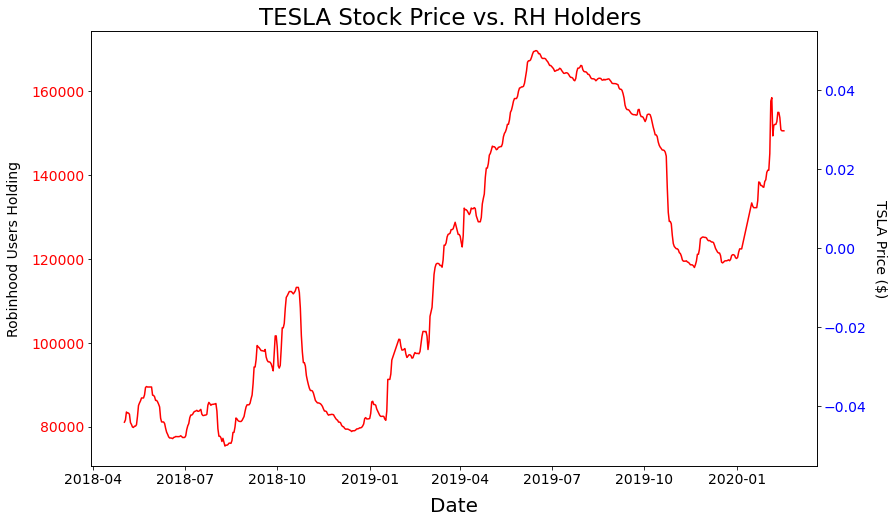

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df_robintrack_tsla["users_holding"], color='r')
ax2=ax.twinx()
ax2.plot(tesla_2018_20['Close/Last'], color='b')

ax.tick_params(axis='y', labelcolor= 'r')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("TSLA Price ($)", rotation=270, labelpad=20, size=14);
ax.set_ylabel('Robinhood Users Holding', size=14, labelpad=10);
ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plt.title("TESLA Stock Price vs. RH Holders ", size=23)
ax.set_xlabel('Date', size=20, labelpad=10);